In [1]:
from google.colab import drive
drive.mount("/content/MyDrive")

Mounted at /content/MyDrive


In [2]:
data_file_path = "/content/MyDrive/MyDrive/Programming/Datasets/PlantVillage/crowdai_train.tar"
extracted_path = "/content/data"

In [3]:
import tarfile
my_tar = tarfile.open(data_file_path)
my_tar.extractall(extracted_path)
my_tar.close()

In [4]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 33.4 MB/s 
     |████████████████████████████████| 181 kB 64.6 MB/s 
     |████████████████████████████████| 145 kB 72.3 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=758e419a80d0fe370477888d95ec33c98ee94f67f35f9c0f33f9fbb1f6ce60f9
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [1]:
import torch
import torchvision
import config
import utils
import models
import wandb
import torchvision.transforms as transforms
from torch.utils.data import SubsetRandomSampler,DataLoader

In [2]:
torch.backends.cudnn.benchmarks = True

torch.backends.cudnn.deterministic = True

wandb.login(key='46f2d6a5ffcc458fed2cca6cf446900f97e396e1')

wandb: Currently logged in as: shashi7679. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
######################################## HYPERPARAMETERS ##############################################

params=dict(
IMAGE_SIZE = config.IMAGE_SIZE,
BATCH_SIZE = config.BATCH_SIZE,
EPOCHS = config.EPOCHS,
LEARNING_RATE = config.LEARNING_RATE,
N_WORKER = 4,
Model="ResNet18",
saved_path = '/content/MyDrive/MyDrive/Programming/Datasets/PlantVillage/saved'
)

In [4]:
wandb.init(project='Plant Diesase Detector',config=params)
params = wandb.config

In [5]:
train_loader,val_loader = utils.get_dataset()
model = models.get_model()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [6]:
model = model.cuda()
criterion = torch.nn.CrossEntropyLoss()
Optimizer = torch.optim.Adam(model.parameters(), lr=config.LEARNING_RATE)

In [7]:
History = []
for epoch in range(config.EPOCHS):
  wandb.watch(model,criterion,log="all")
  #################################################################
  ######################### Training ##############################
  #################################################################
  Epoch_acc = []
  Epoch_loss = []
  model.train()
  for img,label in train_loader:
    img, label = img.cuda(), label.cuda()
    pred = model(img)
    loss = criterion(pred, label)
    loss.backward()
    Optimizer.step()
    Optimizer.zero_grad()
    batch_acc = utils.accuracy(pred, label)
    Epoch_acc.append(batch_acc)
    Epoch_loss.append(loss)

  train_acc = torch.stack(Epoch_acc).mean().item()
  train_loss = torch.stack(Epoch_loss).mean().item()

  print(f"EPOCHS [{epoch+1}]/[{config.EPOCHS}]   Accuracy : {train_acc*100:.4f}   Loss : {train_loss:.4f}")
  ###################################################################
  ########################## Evaluation #############################
  ###################################################################
  val_acc = []
  val_loss = []
  model.eval()
  with torch.no_grad():
    for img, label in val_loader:
      img, label = img.cuda(), label.cuda()
      pred = model(img)
      loss = criterion(pred,label)
      acc = utils.accuracy(pred,label)
      val_loss.append(loss)
      val_acc.append(acc)
    
    val_mean_acc = torch.stack(val_acc).mean().item()
    val_mean_loss = torch.stack(val_loss).mean().item()
  print("##############################")
  print(f"Validation Accuracy : {val_mean_acc*100:.4f}    Validation Loss : {val_mean_loss:.4f}")
  print("##############################")
  utils.train_log(epoch, train_loss, train_acc*100, val_mean_acc*100, val_mean_loss)

  his = {
      'train_acc':train_acc*100,
      'train_loss':train_loss,
      'val_loss':val_mean_loss,
      'val_acc':val_mean_acc*100
  }
  History.append(his)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


EPOCHS [1]/[8]   Accuracy : 78.7402   Loss : 0.9617
##############################
Validation Accuracy : 96.4675    Validation Loss : 0.1538
##############################
EPOCHS [2]/[8]   Accuracy : 97.4848   Loss : 0.1034
##############################
Validation Accuracy : 98.1221    Validation Loss : 0.0676
##############################
EPOCHS [3]/[8]   Accuracy : 98.5401   Loss : 0.0555
##############################
Validation Accuracy : 98.3871    Validation Loss : 0.0514
##############################
EPOCHS [4]/[8]   Accuracy : 99.0477   Loss : 0.0355
##############################
Validation Accuracy : 98.8839    Validation Loss : 0.0348
##############################
EPOCHS [5]/[8]   Accuracy : 99.4240   Loss : 0.0253
##############################
Validation Accuracy : 98.9062    Validation Loss : 0.0361
##############################
EPOCHS [6]/[8]   Accuracy : 99.2985   Loss : 0.0258
##############################
Validation Accuracy : 99.0848    Validation Loss : 0.0276

In [8]:
#model = model.cpu()
saved_path = config.SAVED_PATH + '/' + config.MODEL + '.pth'

In [14]:
checkpoint = {'state_dict': model.state_dict(),'optimizer' :Optimizer.state_dict()}
torch.save(checkpoint, 'Checkpoint.pth')

In [11]:
import shutil
shutil.move("/content/Checkpoint.pth", saved_path)

'/content/MyDrive/MyDrive/Programming/Datasets/PlantVillage/saved/ResNet50.pth'

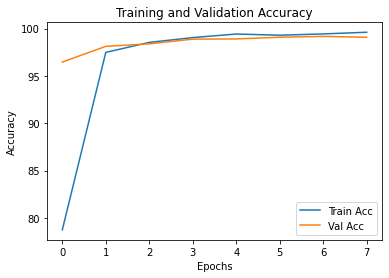

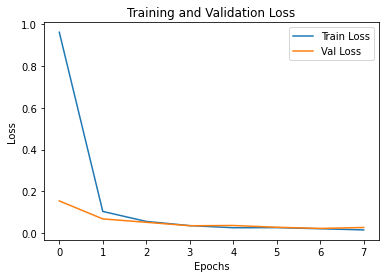

In [12]:
import matplotlib.pyplot as plt
train_acc = []
train_loss = []
val_acc = []
val_loss = []
for i in range(config.EPOCHS):
  temp1 = History[i]['train_acc']
  temp2 = History[i]['train_loss']
  temp3 = History[i]['val_acc']
  temp4 = History[i]['val_loss']

  train_acc.append(temp1)
  train_loss.append(temp2)
  val_acc.append(temp3)
  val_loss.append(temp4)


plt.plot(range(config.EPOCHS),train_acc,label='Train Acc')
plt.plot(range(config.EPOCHS),val_acc,label='Val Acc')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training and Validation Accuracy")
plt.savefig("Training.png")
plt.show()


plt.plot(range(config.EPOCHS),train_loss,label='Train Loss')
plt.plot(range(config.EPOCHS),val_loss,label='Val Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Training and Validation Loss")
plt.savefig("Loss.png")
plt.show()